# Quantum WAV

This example shows tests of generating WAV audio files from quantum circuits by mapping simply state to frequency.  
This mapping has no physical meaning. 
Unfortunately, the sounds were boring as far as I generated and listened to them.
Some improvements are needed for generating interesting sounds.

<h2>
[CAUTION]
Playing generated WAV files may cause loud and noised sounds.
These sounds may damage humans, animals and things, such as PC, speaker, etc.
Please use carefully this codes and generated WAV files.
I (author) don't take responsibility for any damage.
</h2>

In [1]:
# For WAV output.
import wave
import struct
from scipy import fromstring, int16
# from pylab import *

In [2]:
import numpy as np
import itertools
from math import pi
import matplotlib.pyplot as plt
import re

#%matplotlib inline

# qiskit.
from qiskit import (
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
    execute,
    BasicAer,
    Aer,
    transpile,
    assemble,
)
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.providers.aer.library import save_statevector
from qiskit.circuit.library.standard_gates import UGate
from qiskit.circuit.library import XGate, QuadraticForm

print("Imports Successful")


Imports Successful


In [3]:
# Workaround to use qasm.

gate_def_ptn = re.compile('gate\s+(?P<gatename>[^\s\(\)]+)(?P<param>\([^\s\(\)]+\))*\s+(?P<args>[^\s;]+)')
gate_dup_ptn1 = re.compile('gate\s+([^\s\(\)]+)\s+([^\s;]+)\s*{\s*\\1\s+\\2\s*;\s*}')
gate_suf_ptn1 = re.compile('([^_]+)_[0-9]+')

def get_gate_def(qasm):
    m = re.search(gate_def_ptn, qasm)
    return None if m is None else m

def create_gate_repl_str(qasm_list):
    gate_repl_str_list = []
    for qasm in qasm_list:
        m = get_gate_def(qasm)
        if m is None:
            continue
        argn = len(m['args'].split(","))
        if m['param'] is None:
            gate_ptn_str = f"({m['gatename']})\s+(([^\s,]+)(,[^\s,]+){{{argn-1}}})([\s;])"
            gatename = gate_suf_ptn1.sub('\\1', m['gatename'])
            repl_ptn_str = f"{gatename}_{argn} \\2\\{5}"
            gate_repl_str_list.append((gate_ptn_str, repl_ptn_str))
            gate_ptn_str = f"({gatename})\s+(([^\s,]+)(,[^\s,]+){{{argn-1}}})([\s;])"
            repl_ptn_str = f"{gatename}_{argn} \\2\\{5}"
            gate_repl_str_list.append((gate_ptn_str, repl_ptn_str))
        else:
            gate_ptn_str = f"({m['gatename']})\(([^\s\(\)]+)\)\s+(([^\s,]+)(,[^\s,]+){{{argn-1}}})([\s;])"
            gatename = gate_suf_ptn1.sub('\\1', m['gatename'])
            repl_ptn_str = f"{gatename}_{argn}(\\2) \\3\\{6}"
            gate_repl_str_list.append((gate_ptn_str, repl_ptn_str))
            gate_ptn_str = f"({gatename})\(([^\s\(\)]+)\)\s+(([^\s,]+)(,[^\s,]+){{{argn-1}}})([\s;])"
            repl_ptn_str = f"{gatename}_{argn}(\\2) \\3\\{6}"
            gate_repl_str_list.append((gate_ptn_str, repl_ptn_str))
    return gate_repl_str_list

def replace_gate(qasm_list, gate_repl_str_list):
    def replace_one_gate(qasm_list, gate_repl_str):
        gate_ptn_str, repl_ptn_str = gate_repl_str
        gate_ptn = re.compile(gate_ptn_str)
        for i in range(len(qasm_list)):
            qasm_list[i] = gate_ptn.sub(repl_ptn_str, qasm_list[i])
    
    for gate_repl_str in gate_repl_str_list:
        replace_one_gate(qasm_list, gate_repl_str)

def remove_duplicate_def(qasm_list):
    for i in range(len(qasm_list)):
        m = re.search(gate_dup_ptn1, qasm_list[i])
        if m is not None:
            qasm_list[i] = ""


In [4]:
# Split quantum circuit by the barrier.
def create_split_qc_list(qc):
    qc_qasm = qc.qasm()
    initialize = []
    logics = []
    tmp = []
    blockn = 0
    for line, elem in enumerate(qc_qasm.splitlines()):
        if any([elem.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]) or '{' in elem:
            initialize.append(elem)
        elif elem.startswith('barrier'):
            logics.append(tmp)
            tmp = []
            blockn += 1
        else:
            tmp.append(elem)
    if len(tmp) > 0:
        logics.append(tmp)
    remove_duplicate_def(initialize)
    gate_repl_str_list = create_gate_repl_str(initialize)
    replace_gate(initialize, gate_repl_str_list)
    for i in range(len(logics)):
        replace_gate(logics[i], gate_repl_str_list)
    qasm_list = [initialize + logic for logic in logics]
    return [QuantumCircuit.from_qasm_str('\n'.join(qasm)) for qasm in qasm_list]

# Calcurate each statevector output of split quantum circuits.
def get_statevector_list(qc, target_qubit=None):
    def qc_with_initialize(qc, state):
        tmpqc = QuantumCircuit(qc.num_qubits, qc.num_clbits)
        tmpqc.initialize(state, range(qc.num_qubits))
        tmpqc = qc.compose(tmpqc, range(qc.num_qubits), front=True)
        tmpqc.save_statevector()
        return tmpqc
    
    def evolve(qc, state):
        tmpqc = qc_with_initialize(qc, state)
        aer_sim = Aer.get_backend("aer_simulator")
        trans_tmpqc = transpile(tmpqc, aer_sim)
        result = aer_sim.run(trans_tmpqc, shots=1).result()
        return result.data(0)['statevector']
    
    if target_qubit is None:
        target_qubit = list(range(qc.num_qubits))
    trace_qubit = [ i for i in range(qc.num_qubits) if i not in target_qubit ]
    split_qc_list = create_split_qc_list(qc)
    state = Statevector.from_int(0, 2**qc.num_qubits)
    state_list = []
    partial_state = partial_trace(state, trace_qubit).to_statevector()
    state_list.append(partial_state)
    for split_qc in split_qc_list:
        state = evolve(split_qc, state)
        partial_state = partial_trace(state, trace_qubit).to_statevector()
        state_list.append(partial_state)
    return state_list

# Convert statevector to frequency data.
def create_freq_datas(state_list):
    N = 512
    N1 = 1024
    shift = 64
    normal_span = 16
    amp = 10000
    def create_freq_data(state):
        n_state = len(state)
        freq_data_list = []
        if N > n_state:
            span = normal_span
            loop = normal_span
            step = int(N / n_state)
            state_data = state * amp
            tmp_freq_data = np.zeros(N1 ,dtype = 'complex_')
            tmp_freq_data[int((N1-N)/2):int(N1-(N1-N)/2):step] = state_data
            freq_data = np.zeros(N1 ,dtype = 'complex_')
            freq_data[shift:shift+int(N/2)] = tmp_freq_data[int((N1-N)/2):int(N1/2)]
            freq_data[N1-int(N/2)-shift:N1-shift] = tmp_freq_data[int(N1/2):int((N1+N)/2)]
            for l in range(loop):
                freq_data_list.append(freq_data)
        elif normal_span * N > n_state:
            span = normal_span
            loop = int(normal_span * N / n_state)
            step = 1
            state_data = state * amp
            for l in range(loop):
                for k in range(int(n_state/N)):
                    tmp_freq_data = np.zeros(N1 ,dtype = 'complex_')
                    tmp_freq_data[int((N1-N)/2):int(N1-(N1-N)/2):step] = state_data[k*N:(k+1)*N]
                    freq_data = np.zeros(N1 ,dtype = 'complex_')
                    freq_data[shift:int(N/2)+shift] = tmp_freq_data[int((N1-N)/2):int(N1/2)]
                    freq_data[N1-int(N/2)-shift:N1-shift] = tmp_freq_data[int(N1/2):int((N1+N)/2)]
                    freq_data_list.append(freq_data)
        else:
            span = int(n_state / N)
            loop = 1
            step = 1
            state_data = state * amp
            for l in range(loop):
                for k in range(int(n_state/N)):
                    tmp_freq_data = np.zeros(N1 ,dtype = 'complex_')
                    tmp_freq_data[int((N1-N)/2):int(N1-(N1-N)/2):step] = state_data[k*N:(k+1)*N]
                    freq_data = np.zeros(N1 ,dtype = 'complex_')
                    freq_data[shift:int(N/2)+shift] = tmp_freq_data[int((N1-N)/2):int(N1/2)]
                    freq_data[N1-int(N/2)-shift:N1-shift] = tmp_freq_data[int(N1/2):int((N1+N)/2)]
                    freq_data_list.append(freq_data)
        return freq_data_list, span
    
    total_freq_data_list = []
    for state in state_list:
        state_np = np.array(state)
        freq_data_list, span = create_freq_data(state_np)
        # total_freq_data_list.append(freq_data_list)
        total_freq_data_list.extend(freq_data_list)
    
    return total_freq_data_list, span

def inverse_fourier_2ch(k):
    ch1 = []
    ch2 = []
    for sample in k:
        inv = np.fft.ifft(sample)
        # tmp = np.where(inv < 0, 0, inv)
        ch1.extend(inv.real)
        ch2.extend(inv.imag)
    return ch1, ch2

def compose_wav_2ch(ch1, ch2):
    ret = []
    number = len(ch1) if len(ch2) > len(ch1) else len(ch2)
    for i in range(0, number -1):
        data = [int(ch2[i]), int(ch1[i])]
        ret.extend(data)
    return ret

## Test 1: Not Quantum

In [5]:
def classic_qc():
    qc = QuantumCircuit(4)
    qc.x(0)
    qc.barrier()
    qc.x(1)
    qc.barrier()
    qc.x(2)
    qc.barrier()
    qc.x(1)
    qc.barrier()
    qc.x(3)
    return qc


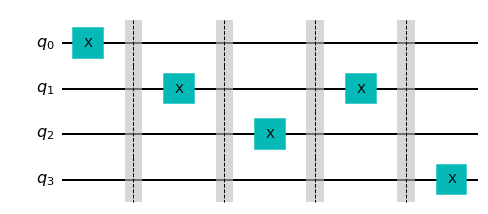

In [6]:
# Make a quantum circuit.
qc = classic_qc()
qc.draw(output="mpl")

In [7]:
# Simulation.
state_list = get_statevector_list(qc)
total_freq_data_list, span = create_freq_datas(state_list)
print(len(total_freq_data_list))

96


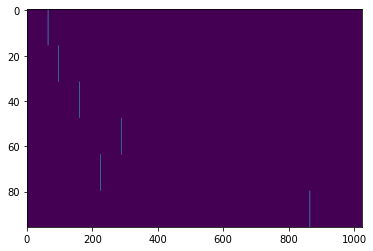

In [8]:
# Plot sound frequency spectra.
# time (col) v.s. frequency (row).
frand_np = np.array(total_freq_data_list)
data = np.sqrt(frand_np.real**2 + frand_np.imag**2)
plt.imshow(data, aspect='auto')

In [9]:
# Make a WAV file.
ch1, ch2 = inverse_fourier_2ch(total_freq_data_list)
raw_data = compose_wav_2ch(ch1, ch2)
out_data = struct.pack("h" * len(raw_data), *raw_data)
ch = 2
width = 2
framerate = 22050
outf = 'test1.wav'
ww = wave.open(outf, 'w')
ww.setnchannels(ch)
ww.setsampwidth(width)
ww.setframerate(framerate)
ww.writeframes(out_data)
ww.close()

# Test 2: Quantum Switch

In [10]:
# Reference: https://github.com/schrodingers-koala/quantum-playground/blob/main/quantum_switch.ipynb
def qswitch_g(qc, f, g, measure_flag=True):    
    qc.h(3)
    qc.cx(3,2)

    qc.barrier()
    
    qc.fredkin(0, 1, 2)
    qc.x(0)
    g(qc, 1)
    f(qc, 2)
    qc.fredkin(0, 1, 2)

    qc.barrier()

    qc.cx(2,3)
    qc.h(2)
    
    qc.barrier()

    if measure_flag:
        qc.measure(2, 0)
        qc.measure(3, 1)

    qc.barrier()
    
    return qc

def qswitch_qc(control_x, p_i, p_f, p_g, p_i2=pi/2, p_f2=pi/2, p_g2=pi/2, measure_flag=True, qs_measure_flag=True):  
    theta_i, phi_i, lmd_i = p_i, p_i2, p_i2
    theta_f, phi_f, lmd_f = p_f, p_f2, p_f2
    theta_g, phi_g, lmd_g = p_g, p_g2, p_g2
    def ini(qc, q):
        qc.u(theta_i, phi_i, lmd_i, q)
        
    def f(qc, q):
        qc.u(theta_f, phi_f, lmd_f, q)

    def g(qc, q):
        qc.u(theta_g, phi_g, lmd_g, q)

    def inv_ini(qc, q):
        qc.u(-theta_i, -lmd_i, -phi_i, q)

    def inv_f(qc, q):
        qc.u(-theta_f, -lmd_f, -phi_f, q)

    def inv_g(qc, q):
        qc.u(-theta_g, -lmd_g, -phi_g, q)

    # Initialize
    qc = QuantumCircuit(4, 3)
    if control_x == 1: # quantum switch conrtol
        qc.x(0)
    ini(qc, 1)
    qc.barrier()
    # quantum switch
    qswitch_g(qc, f, g, measure_flag=qs_measure_flag)
    # reverse
    if control_x == 1:
        inv_g(qc, 1)
        inv_f(qc, 1)
    else:
        inv_f(qc, 1)
        inv_g(qc, 1)

    inv_ini(qc, 1)
    
    if measure_flag:
        qc.measure(1, 2)

    return qc


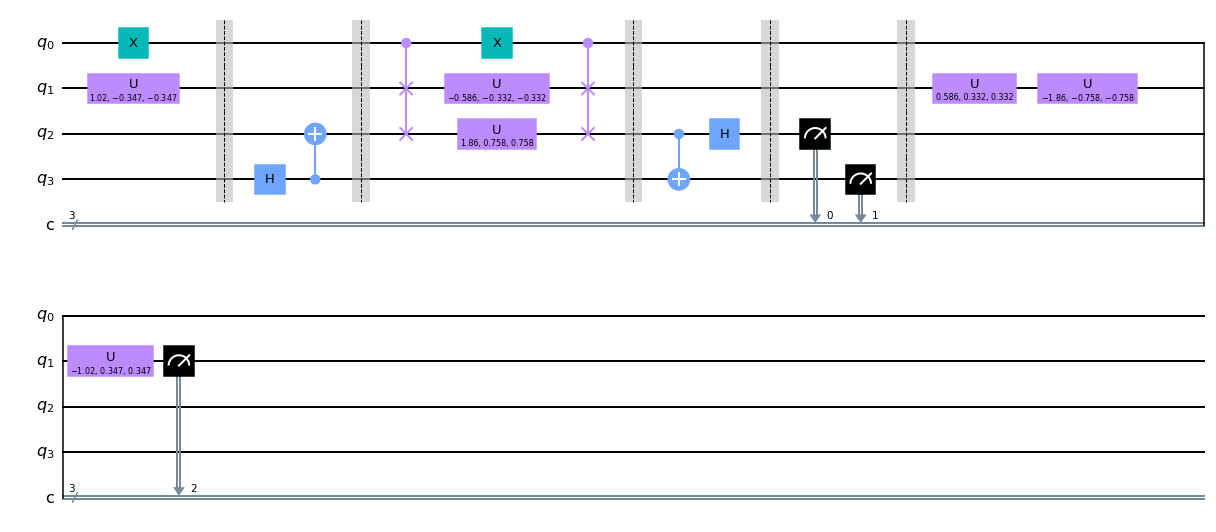

In [11]:
# Make a quantum circuit.
# This example measures q1, q3, q2.
control_x = 1
not_control_x = ~control_x & 1
p_i, p_f, p_g = tuple((np.random.rand(3)-0.5)*2*pi)
p_i2, p_f2, p_g2 = tuple((np.random.rand(3)-0.5)*2*pi)
qc = qswitch_qc(control_x, p_i, p_f, p_g, p_i2=p_i2, p_f2=p_f2, p_g2=p_g2, measure_flag=True, qs_measure_flag=True)
qc.draw(output="mpl")

In [12]:
# Simulation.
state_list = get_statevector_list(qc)
total_freq_data_list, span = create_freq_datas(state_list)
print(len(total_freq_data_list))

112


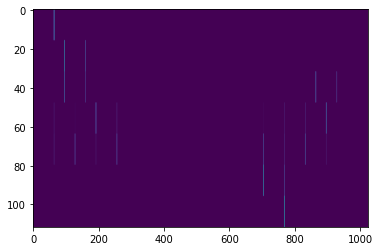

In [13]:
# Plot sound frequency spectra.
# time (col) v.s. frequency (row).
frand_np = np.array(total_freq_data_list)
data = np.sqrt(frand_np.real**2 + frand_np.imag**2)
plt.imshow(data, aspect='auto')

In [14]:
# Make a WAV file.
ch1, ch2 = inverse_fourier_2ch(total_freq_data_list)
raw_data = compose_wav_2ch(ch1, ch2)
out_data = struct.pack("h" * len(raw_data), *raw_data)
ch = 2
width = 2
framerate = 22050
outf = 'test2.wav'
ww = wave.open(outf, 'w')
ww.setnchannels(ch)
ww.setsampwidth(width)
ww.setframerate(framerate)
ww.writeframes(out_data)
ww.close()

# Test 3: Regular Uniform Designs

In [15]:
def result_top_n(result, n):
    res = [ [k, v] for k, v in result.items() ]
    res.sort(key=lambda x: x[1], reverse=True)
    k, v = zip(*res[0:min(len(result), n)])
    return dict(zip(k, v))

def print_result(result, v, b, r, k, n):
    res = [ [k, v] for k, v in result.items() ]
    res.sort(key=lambda x: x[1], reverse=True)
    p = res[n][0]
    for i in range(int(len(p)/b)):
        print(p[i*b:(i*b+b)])

In [16]:
# Reference: https://github.com/schrodingers-koala/jupyter-jobstorm/blob/main/example/rud.ipynb
# Apply x gate to target qubit if control_qubits[i] == 1 for any i.
def cnx(qc, cqlist, tq):
    n = len(cqlist)
    cnx_gate = XGate().control(n)
    qc.append(cnx_gate, cqlist + [tq])

# Apply x gate to target qubit if control_qubits is the binary representation of n.
def eqx(qc, cqlist, tq, n):
    bindata = bin(n)
    rblist = list(map(lambda x: int(x), bindata[2:]))
    blist = list(reversed(rblist))
    bidx = ([i for i, x in enumerate(blist) if x == 1])
    for i in range(len(cqlist)):
        if i in bidx:
            continue
        qc.x(cqlist[i])
    cnx(qc, cqlist, tq)
    for i in range(len(cqlist)):
        if i in bidx:
            continue
        qc.x(cqlist[i])

# Apply x gate to target qubit if the sum of qubits is n.
def sumeqx(qc, sumqlist, workqlist, tq, n):
    qubits = len(bin(len(sumqlist))) - 2
    tmpqlist = workqlist[0:qubits]
    qf = QuadraticForm(num_result_qubits=qubits, linear=[1]*len(sumqlist))
    qc.append(qf, sumqlist + tmpqlist)
    eqx(qc, tmpqlist, tq, n)
    qc.append(qf.inverse(), sumqlist + tmpqlist)

# Make a quantum circuit which verifies regular uniform designs.
def rud_oracle(qc, v, b, r, k):
    if b*k != v*r:
        raise ValueError("b*k != v*r")
    
    p = np.arange(v * b)
    matp = p.reshape([v, b])
    colp = matp.tolist()
    rowp = matp.transpose().tolist()
    
    n_p = len(p)
    n_col = len(colp)
    n_row = len(rowp)
    n_tmp = (len(bin(max(v, b))) - 2)
    n_req_qubits = n_p + n_col + n_row + n_tmp + 1

    n_qubits = len(qc.qubits)
    if n_req_qubits > n_qubits:
        raise ValueError(f"rud circuit need qubits > {n_req_qubits}")

    pq = list(range(0, n_p))
    colq = list(range(n_p, n_p + n_col))
    rowq = list(range(n_p + n_col, n_p + n_col + n_row))
    tmpq = list(range(n_p + n_col + n_row, n_p + n_col + n_row + n_tmp))
    tq = n_p + n_col + n_row + n_tmp
    
    for i, col in enumerate(colp):
        sumeqx(qc, list(col), tmpq, colq[i], r)
    for i, row in enumerate(rowp):
        sumeqx(qc, list(row), tmpq, rowq[i], k)
    cnx(qc, colq + rowq, tq)
    for i, col in enumerate(colp):
        sumeqx(qc, list(col), tmpq, colq[i], r)
    for i, row in enumerate(rowp):
        sumeqx(qc, list(row), tmpq, rowq[i], k)
    return pq, colq, rowq, tmpq, tq

# One step of Grover algorithm
def rud_grover_step(qc, v, b, r, k):
    pq, colq, rowq, tmpq, tq = rud_oracle(qc, v, b, r, k)
    for i in pq:
        qc.h(i)
        qc.x(i)
        if i==pq[-1]:
            qc.h(i)
    cnx(qc, pq[0:-1], pq[-1])
    for i in pq:
        qc.h(i)
        qc.x(i)
        if i==pq[-1]:
            qc.h(i)

# Grover algorithm
def rud_grover(v, b, r, k, itn):
    n_p = v * b
    n_col = v
    n_row = b
    n_tmp = (len(bin(max(v, b))) - 2)
    n_req_qubits = n_p + n_col + n_row + n_tmp + 1
    
    qc = QuantumCircuit(n_req_qubits, n_p)
    for i in range(n_p):
        qc.h(i)
    qc.x(n_req_qubits - 1)
    qc.h(n_req_qubits - 1)
    for loop in range(itn):
        rud_grover_step(qc, v, b, r, k)
        qc.barrier()
    #for i in range(n_p):
    #    qc.measure(i, i)
    return qc

In [17]:
# Make a quantum circuit.
param_vbrk = (3, 3, 1, 1)
steps = 2
qc = rud_grover(*param_vbrk, steps)
aer_sim = Aer.get_backend("aer_simulator")
trans_qc = transpile(qc, aer_sim)

In [18]:
# Simulation.
state_list = get_statevector_list(qc, list(range(9)))
total_freq_data_list, span = create_freq_datas(state_list)
print(len(total_freq_data_list))

48


In [19]:
result = state_list[2].sample_counts(shots=4096)
# Get top 10 solutions
result10 = result_top_n(result, 10)
# print result[0]
print_result(result10, *param_vbrk, 0)

100
010
001


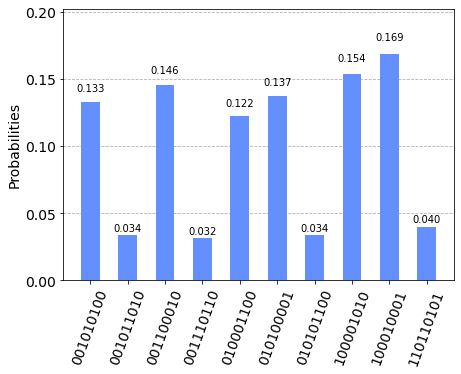

In [20]:
plot_histogram(result10)

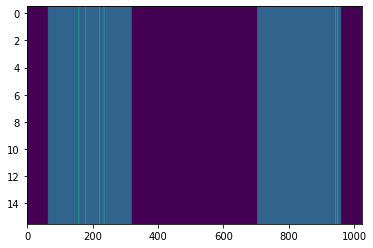

In [21]:
# Plot sound frequency spectra.
# time (col) v.s. frequency (row).
frand_np = np.array(total_freq_data_list)
data = np.sqrt(frand_np.real**2 + frand_np.imag**2)
plt.imshow(data[16*1:16*2,:], aspect='auto')
# plt.imshow(data, aspect='auto')

In [22]:
# Make a WAV file.
ch1, ch2 = inverse_fourier_2ch(total_freq_data_list)
raw_data = compose_wav_2ch(ch1, ch2)
out_data = struct.pack("h" * len(raw_data), *raw_data)
ch = 2
width = 2
framerate = 22050
outf = 'test3.wav'
ww = wave.open(outf, 'w')
ww.setnchannels(ch)
ww.setsampwidth(width)
ww.setframerate(framerate)
ww.writeframes(out_data)
ww.close()